# Bikeshare Station Exploration

The purpose of this notebook is to explore and model bikeshare usage in the San Francisco area. The datasets used are:

- Station data: Consists of the name, location (coordinates and city), and dock size of all 76 bike docks.
- Trip data: Records of over 354,000 trips over the course of one year, from 9/1/2014 to 8/31/2015. Includes the start/end times and start/end stations of each trip. 
- Weather data: Includes weather and temperature readings of each day of the study year in each city zip code.

The notebook imports and cleans these datasets, combines and transforms them, performs a data exploration, and finally models the trip data to predict the net rate of change at each bikeshare station. The model attempts to answer the question "Given the time of day and current weather, what is the change in bikes per station?"

This is intended to help the bikeshare company coordinate supply and demand of bikes at different stations throughout the area. 

- [Data Import and Clean](#import)
- [Data Transform](#transform)
- [Data Exploration](#exploration)
- [Model Selection](#model)
    - [Random Forest Regression](#RF)
    - [XGBoost Regression](#XGB)
- [Conclusion and Extensions](#conclusion)


In [2]:
# Import packages

from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns
!pip install xgboost
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', 50)


You should consider upgrading via the 'python -m pip install --upgrade pip' command.
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data Import and Clean <a name="import"></a>

In [2]:
# Import datasets as Panda dataframes
stations = pd.read_csv('station_data.csv')
trips = pd.read_csv('trip_data.csv')
weather = pd.read_csv('weather_data.csv')

In [3]:
# Check counts of each dataframe
stations.count()
trips.count()
weather.count()

Date                         1825
Max TemperatureF             1821
Mean TemperatureF            1821
Min TemperatureF             1821
Max Dew PointF               1775
MeanDew PointF               1775
Min DewpointF                1775
Max Humidity                 1775
Mean Humidity                1775
Min Humidity                 1775
Max Sea Level PressureIn     1824
Mean Sea Level PressureIn    1824
Min Sea Level PressureIn     1824
Max VisibilityMiles          1820
Mean VisibilityMiles         1820
Min VisibilityMiles          1820
Max Wind SpeedMPH            1824
Mean Wind SpeedMPH           1824
Max Gust SpeedMPH            1284
PrecipitationIn              1824
CloudCover                   1824
Events                        287
WindDirDegrees               1824
Zip                          1825
dtype: int64

In [4]:
# Check the data types

# All datatypes look reasonable to work with. 
stations.dtypes
trips.dtypes
weather.dtypes

Date                          object
Max TemperatureF             float64
Mean TemperatureF            float64
Min TemperatureF             float64
Max Dew PointF               float64
MeanDew PointF               float64
Min DewpointF                float64
Max Humidity                 float64
Mean Humidity                float64
Min Humidity                 float64
Max Sea Level PressureIn     float64
Mean Sea Level PressureIn    float64
Min Sea Level PressureIn     float64
Max VisibilityMiles          float64
Mean VisibilityMiles         float64
Min VisibilityMiles          float64
Max Wind SpeedMPH            float64
Mean Wind SpeedMPH           float64
Max Gust SpeedMPH            float64
PrecipitationIn              float64
CloudCover                   float64
Events                        object
WindDirDegrees               float64
Zip                            int64
dtype: object

In [5]:
stations['City'].value_counts()

San Francisco    39
San Jose         16
Redwood City      9
Mountain View     7
Palo Alto         5
Name: City, dtype: int64

We can see that the majority of the stations in our data exist within San Francisco (39 stations). 

## Data Transform <a name="transform"></a>


In [6]:
# Create the net rate of each station
# Calculate the trips ended - trips started by hour for each station

# Change column names for easier reading
trips.columns = ['ID', 'start', 'start_station','end','end_station','type']

# Change the start and end colums to dateime in order to transform
trips.end=pd.to_datetime(trips.end)
trips.start=pd.to_datetime(trips.start)

# Drop ID and type variables since we won't use them
trips.drop(columns=["ID", "type"],inplace=True)

# Group the trips data by hour and end station count
trips_s = trips.groupby([pd.Grouper(key='start',freq='H'),trips.start_station]).size().reset_index(name='left')
trips_e = trips.groupby([pd.Grouper(key='end',freq='H'),trips.end_station]).size().reset_index(name='arrive')

In [7]:
# Merge the two groups by datetime

# Rename the ID column so that it can be merged on this attribute
trips_s = trips_s.rename(index=str, columns={"start": "date"})
trips_e = trips_e.rename(index=str, columns={"end": "date"})

# Merge into a single dataframe
trips_merged = trips_s.merge(trips_e, how = 'inner', on = 'date')
trips_merged

# Set datetime as index
trips_merged.set_index('date')



,start_station,left,end_station,arrive
date,,,,
2014-01-09 00:00:00,66,3,57,3
2014-01-09 04:00:00,39,1,65,1
2014-01-09 04:00:00,66,1,65,1
2014-01-09 05:00:00,68,1,70,1
2014-01-09 05:00:00,68,1,72,1
2014-01-09 06:00:00,67,1,74,1
2014-01-09 07:00:00,9,1,51,1
2014-01-09 07:00:00,9,1,77,1
2014-01-09 07:00:00,27,2,51,1


In [8]:
# Sort by arrival and end station
trips_merged.sort_values(['start_station', 'end_station'], ascending=[True, True], inplace= True)

# Calculate the net change of each station by hour 
trips_merged['net'] = trips_merged['arrive'] - trips_merged['left']

# Assign date time variables - hour of day, day of week, and week of year
trips_merged['day'] = trips_merged['date'].dt.dayofweek
trips_merged['week'] = trips_merged['date'].dt.week
trips_merged['hour'] = trips_merged['date'].dt.hour
trips_merged["date_merge"] = trips_merged['date'].dt.date

In [9]:
# With net rate calculated, add station information for our model building

# Rename stations columns and trips columns
stations = stations.rename(index=str, columns={"Id": "station_num", "Dock Count" : "dock_count", "Name":"station_name"})
trips_merged = trips_merged.rename(index=str, columns={"start_station" : "station_num"})

# Merge the two on station/dock ID
trips_merged = trips_merged.merge(stations, how = 'inner', on = 'station_num')

# Drop the variables we no longer need, including the trip start/end information since we've calculated the net rate
trips_merged.drop(columns=["left", "end_station", "arrive", "Lat", "Long"],inplace=True)



In [10]:
# Join the weather data to the station data based on zipcode and city info

# Replace city with zipcode, and convert to int
trips_merged['city_zip'] = trips_merged['City'].replace({'San Francisco':'94107', 'Redwood City' : '94063', 'Palo Alto':'94301', 'Mountain View': '94041', 'San Jose': '95113'})
trips_merged['city_zip'] = pd.to_numeric(trips_merged['city_zip'])

# Convert weather and trips date_merge to datetime for join.
trips_merged.date_merge=pd.to_datetime(trips_merged.date_merge)
weather.Date=pd.to_datetime(weather.Date)
weather = weather.rename(index=str, columns={"Date": "date_merge", "Zip" : "City"})

# Merge the trip and weather data together based on date and city
trips_merged = pd.merge(trips_merged, weather,  how='left', left_on=['date_merge','city_zip'], right_on = ['date_merge','City'])

# Drop the variables we will no longer be using (dates, station name, city name). Max gust dropped due to sparse data.
trips_merged.drop(columns=["date_merge", "Events", "Max Gust SpeedMPH","City_y", "date", "station_name", "City_x"],inplace=True)

# Finally, drop rows that have NaN data - removes 7,428 records (out of 3,696,151)
trips_merged = trips_merged.dropna()

## Data Exploration <a name="exploration"></a>

At this point, lets only explore and model the San Francisco stations as they have the largest sample size.

In [11]:
# Slice our complete dataset to only include the stations within San Francisco (39 total stations)
sf_trips = trips_merged.loc[trips_merged['city_zip'] == 94107]

sf_trips.head()

,station_num,net,day,week,hour,dock_count,city_zip,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressureIn,Mean Sea Level PressureIn,Min Sea Level PressureIn,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,PrecipitationIn,CloudCover,WindDirDegrees
601801,39,-1,3,2,14,19,94107,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,29.86,29.82,29.76,10.0,10.0,8.0,16.0,7.0,0.0,0.0,290.0
601802,39,3,4,2,7,19,94107,83.0,68.0,53.0,60.0,51.0,40.0,93.0,58.0,22.0,29.98,29.90,29.85,10.0,10.0,8.0,15.0,4.0,0.0,1.0,283.0
601803,39,-5,4,2,9,19,94107,83.0,68.0,53.0,60.0,51.0,40.0,93.0,58.0,22.0,29.98,29.90,29.85,10.0,10.0,8.0,15.0,4.0,0.0,1.0,283.0
601804,39,0,4,2,12,19,94107,83.0,68.0,53.0,60.0,51.0,40.0,93.0,58.0,22.0,29.98,29.90,29.85,10.0,10.0,8.0,15.0,4.0,0.0,1.0,283.0
601805,39,-2,4,2,14,19,94107,83.0,68.0,53.0,60.0,51.0,40.0,93.0,58.0,22.0,29.98,29.90,29.85,10.0,10.0,8.0,15.0,4.0,0.0,1.0,283.0


With the data split by San Francisco data, we can perform some basic data exploration of some of the variables. 

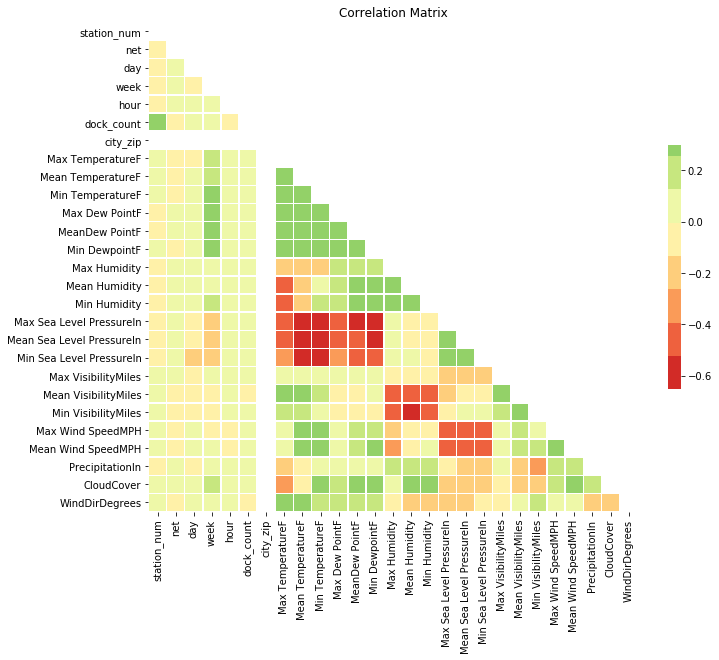

In [12]:
# Calculate correlations and visualize in a correlation matrix. Allows us to identify dependencies between attributes. 

# We will use a Pearson heatmap to visualize.
corr = sf_trips.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.color_palette("RdYlGn", 10)

# Draw the heatmap with the mask and correct aspect ratio
op = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


op = plt.title('Correlation Matrix')

Not surprisingly, many of the weather attributes are correlated one way or another. However, we can see that the net change attribute does not seem to be correlated at all with weather attributes. 

C:\Users\Robert\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


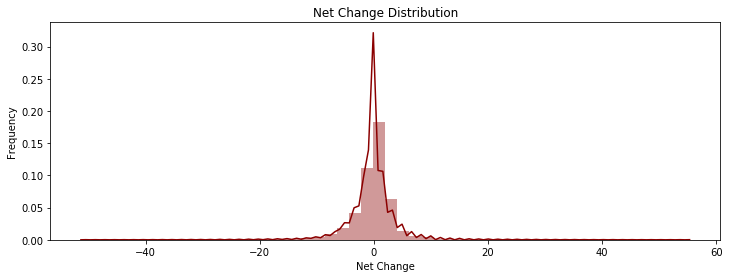

In [13]:
# Net change histogram
plt.figure(figsize=(12, 4))

# distplot itself determines the size of the bins according to the Freedman-Diaconis rule
ax = sns.distplot(sf_trips['net'], hist=True, color='darkred')
ax.set(ylabel="Frequency", xlabel="Net Change")
ax = plt.title('Net Change Distribution')



The net change attribute has a normal distribution and a mean average of -0.26. 

Now, lets look at the temporal nature of the trips by how many trips are made each week, day, and hour.

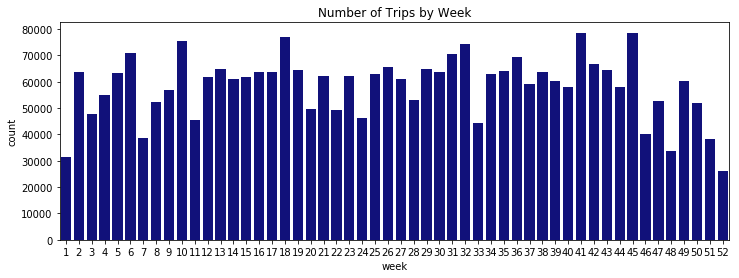

In [14]:
# Plot the number of trips made each week of the year

plt.figure(figsize=(12,4))
ax=sns.countplot(x=sf_trips['week'], color="darkblue").set_title('Number of Trips by Week')


There does not appear to be any clear pattern of the number of trips throughout the year. The first and last weeks of the year are the lowest, which correspond with the Christmas and New Year holidays. 

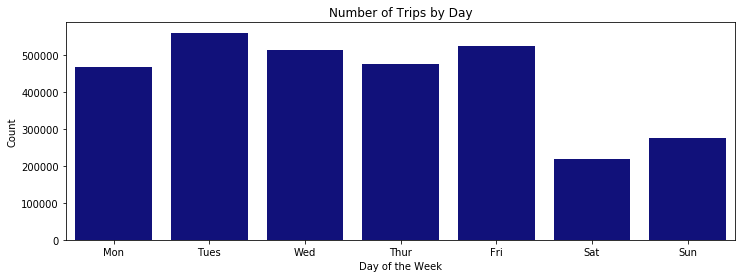

In [15]:
# Plot the number of trips made each day of the week

days = ['Mon', 'Tues', "Wed", 'Thur', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(12,4))
ax=sns.countplot(x=sf_trips['day'], color="darkblue")
ax = ax.set(xticks=range(len(days)), xticklabels=[i[0:4] for i in days])
plt.xlabel("Day of the Week")
plt.ylabel("Count")
plt.title("Number of Trips by Day")
plt.show()

By day of the week, we see that Tuesday and Friday are the most used days of the week. The weekends are the lowest. This suggests that the bikeshares are used most commonly for commuting.

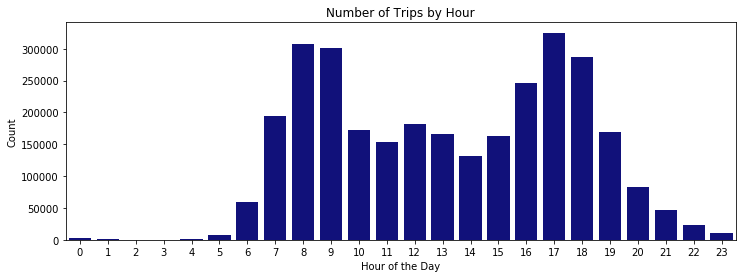

In [16]:
# Plot the number of trips made each hour of the day


plt.figure(figsize=(12,4))
ax=sns.countplot(x=sf_trips['hour'], color="darkblue")

plt.xlabel("Hour of the Day")
plt.ylabel("Count")
plt.title("Number of Trips by Hour")
plt.show()

Looking at trip usage by hour of the day reinforces that the bikes are most often used for commuting, as the two peaks of usage throughout the day are mornings (8-9 am) and evenings (4-6 pm).

We can split our trips by weekday vs weekend to see how the hourly patterns change.

In [17]:
# Split trips by weekday vs weekend

sf_trips_day = sf_trips.loc[(sf_trips['day'] != 5) & (sf_trips['day'] != 6)]
sf_trips_end= sf_trips.loc[sf_trips['day'].isin([5,6])]

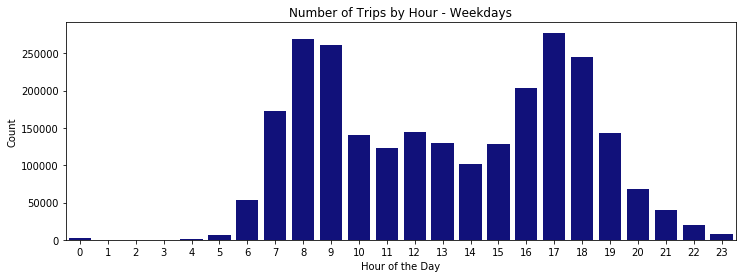

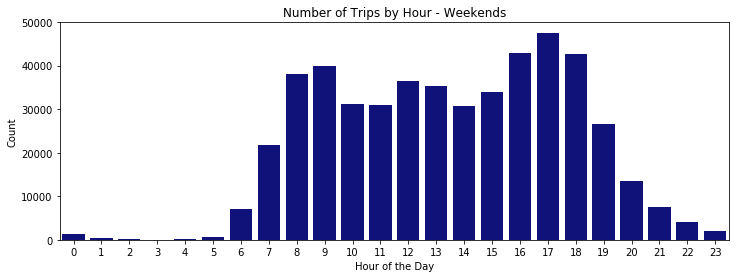

In [18]:
# PLot the weekday vs weekend hourly usage

plt.figure(figsize=(12,4))
ax=sns.countplot(x=sf_trips_day['hour'], color="darkblue")

plt.xlabel("Hour of the Day")
plt.ylabel("Count")
plt.title("Number of Trips by Hour - Weekdays")
plt.show()

plt.figure(figsize=(12,4))
ax=sns.countplot(x=sf_trips_end['hour'], color="darkblue")

plt.xlabel("Hour of the Day")
plt.ylabel("Count")
plt.title("Number of Trips by Hour - Weekends")
plt.show()

Looking at the hourly usage split by weekday vs weekend, we see that the weekend usage is more evenly spread throughout the day. That said, there still appears to be morning and evening peaks. However, they are not as extreme as the weekday trips.

## Model Selection <a name="model"></a>

Using our San Francisco trip data, we will now build and compare two different machine learning regression models to predict the net change of bikes. The variables (x) used to predict the net change (y) include the weather information and temporal details (week, day, hour) of our trip data. 

The two models we will construct and compare are Random Forest and XGBoost (an advanced form of gradient boosting). Neither model requires normalized data, which is a strength. 

In [19]:
# First, we have a very large amount of hourly trip data (over 3 million records). For this excercise we will only
# work with a subset of this so that the model building and evaluation is quicker. 
# We will limit our modeling data to a single month rather than an entire year. 

# Reduce our SF data to a single month. We'll use June 2015 plus the first week of July (weeks 23-27). 
sf_trips_june = sf_trips.loc[sf_trips['week'].isin([23,24,25,26,27])]


In [20]:
# Second, using the correlation results from above, we will drop unhelpful or redundant variables from our data.
# This includes the zipcode and week variables, as well as all the max/min temperature readings. 
# By only including the daily averages we'll speed up our model performance.

sf_trips_june = sf_trips_june.drop(['city_zip','week','Max TemperatureF','Min TemperatureF','Max Dew PointF','Min DewpointF','Max Humidity','Min Humidity','Max VisibilityMiles','Min VisibilityMiles','Max Wind SpeedMPH','Max Sea Level PressureIn','Min Sea Level PressureIn',], axis=1)

We have now dramatically reduced our dataframe (by removing unnecessary variables) and data size (from over 3 million records to nearly 300k. This will help speed up our modeling and performance analysis.

### Random Forest Regression <a name="RF"></a>

The random forest combines hundreds or thousands of decision trees, trains each one on a slightly different set of the observations, splitting nodes in each tree considering a limited number of the features. The final predictions of the random forest are made by averaging the predictions of each individual tree.

The random forest is a model made up of many decision trees. Rather than just simply averaging the prediction of trees (which we could call a “forest”), this model uses two key concepts that gives it the name random:

- Random sampling of training data points when building trees
- Random subsets of features considered when splitting nodes

The idea is that by training each tree on different samples, although each tree might have high variance with respect to a particular set of the training data, overall, the entire forest will have lower variance but not at the cost of increasing the bias

At test time, predictions are made by averaging the predictions of each decision tree. This procedure of training each individual learner on different bootstrapped subsets of the data and then averaging the predictions is known as bagging, short for bootstrap aggregating.

The feature importances in a random forest indicate the sum of the reduction in Gini Impurity over all the nodes that are split on that feature. We can use these to try and figure out what predictor variables the random forest considers most important. Feature importances can give us insight into a problem by telling us what variables are the most discerning between classes.

In [21]:
# Split data into x and y features. What we are predicting (net rate = y), and the variables we're using (all other variables = x)

y = sf_trips_june.iloc[:,1:2] # The 'net rate' category
x = sf_trips_june.drop(['net'], axis=1) # All explanatory variables


In [22]:
# With the data organized, we will now split it into training and testing sets. 
#We use the train_test_split tool to do this for us. We will use 80% of the data to train our Random Forest model.

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.20, random_state = 1234)

# Check the sizes of our subsets
print("The number of trips in our attribute training set is: " + str(len(train_x)))
print("The number of trips in our attribute testing set is: " + str(len(test_x)))
print("The number of trips in our label training set is: " + str(len(train_y)))
print("The number of trips in our label testing set is: " + str(len(test_y)))

The number of trips in our attribute training set is: 238207
The number of trips in our attribute testing set is: 59552
The number of trips in our label training set is: 238207
The number of trips in our label testing set is: 59552


We now have our data split into training (238,207 records) and testing (59,552 records).

To build our model, we will use the GridSearchCV tool. The tool finds the best parameter settings based on cross-validation - a vital model refinement tool to judge the measure of fit. Cross validation executes model training and validation on multiple subsets of the data to evaluate the ability to predict new data that was not used in the training. This helps avoid the potential problems of overfitting or selection bias. We'll do this despite the fact that a strength of the Random Forest algorithm is avoidence of overfitting.

The main parameters we will decide between are the number of trees to use in the forest (n_estimators), the depth of the trees (max_depth), and the number of features to consider when deciding on the best split (max_features). We will not hyperparamtize the max_features and max_depth in this exercise due to the extensive processing time involved.

As a scoring metric, we will use Mean Absolute Error (MAE) as it is not as sensitive to outliers as MSE (Mean Squared Error). In our case, we don't think that prediction errors are significantly detrimental.


In [23]:
# Cell is commented out so that it doesn't run again as grid search is time consuming.

# Setup our parameters for the Random Forest grid search with the hyperparameters.
##parameters = {'n_estimators' : [10, 100, 500]}

# Perform the grid search for the Random Forest regression based on our parameters.
# In the cross validation, we are using 5 k-folds and use Mean Absolute Error (MAE) as our scoring metric.
##regressor = GridSearchCV(RandomForestRegressor(random_state=1234), parameters, cv=5, scoring ='neg_mean_absolute_error', return_train_score=True)

# Finally, run the grid search on our training data
##regressor.fit(train_x, train_y.values.ravel())

# Print out the scores of the different parameters
##print("The best parameters identified are: " + str(regressor.best_params_))
##result = pd.DataFrame(regressor.cv_results_)
##result[['mean_test_score', 'std_test_score', 'params','rank_test_score']]

The best parameters identified are: {'n_estimators': 500}


,mean_test_score,std_test_score,params,rank_test_score
0,-1.938940,0.004450,{'n_estimators': 10},4
1,-1.935035,0.005220,{'n_estimators': 50},3
2,-1.934690,0.004971,{'n_estimators': 100},2
3,-1.934278,0.005011,{'n_estimators': 500},1


Not surprisingly, the model with the greatest number of trees (500) performed the best. In full model development, we would further tune this in addition to other hyperparameters (max_features and max_depth in particular).

In [25]:
# With our optimal settings found, we can use the optimal parameter setting to make predictions
predictions = regressor.predict(test_x)

# View the scoring results of these predictions and review performance

print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(test_y, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, predictions)))

Mean Absolute Error: 1.9371551136701526
Mean Squared Error: 11.51181014827531
Root Mean Squared Error: 3.3929058560878627


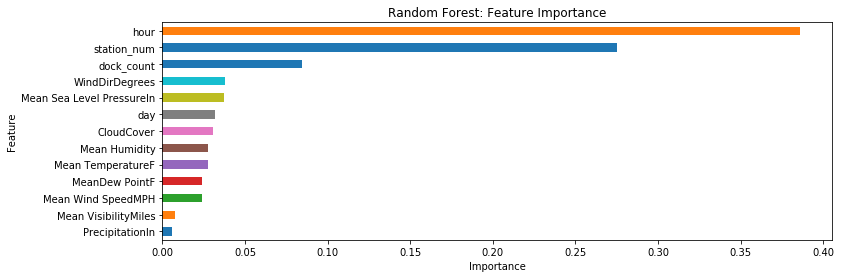

In [32]:
# Finally, we can use the feature importance element of our random forest results 
# to view the importance of each feature to model predictions

# Plot feature importances
fig, ax = plt.subplots(figsize=(12, 4))
feat_importances = pd.Series(regressor.best_estimator_.feature_importances_, index=train_x.columns)

feat_importances= feat_importances.sort_values(ascending=True)

feat_importances.plot(kind='barh')
plt.title('Random Forest: Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

We can see that the hour of the day is the most important feature for the model in making predictions. This is followed by station number, which indicates a spatial/geographic connection importance. Sea level pressure and wind direction proved to be the most important weather features.

### XGBoost Regression <a name="XGB"></a>

The XGBoost library implements the gradient boosting decision tree algorithm. This algorithm goes by lots of different names such as gradient boosting, multiple additive regression trees, stochastic gradient boosting or gradient boosting machines. The basic idea behind boosting algorithms is building a weak model, make conclusions about the feature importances and parameters, and then using those conclusions to build a new, stronger model to capitalize on the misclassification error of the previous model and try to reduce it. This approach can be used in both regression and classification modeling problems. 

Boosting is an ensemble technique where new models are added to correct the errors made by existing models. Models are added sequentially until no further improvements can be made. It works be creating new models that predict the residuals/errors of prior models, and are then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models. 

For example, the AdaBoost algorithm weights data points that are harder to predict. At any instant t, the model outcomes are weighed based on the outcomes of previous instant t-1. The outcomes predicted correctly are given a lower weight and the ones miss-classified are weighted higher (the harder to predict data points).

Essentially, boosting is as an optimization algorithm on a cost function. It works by building a model from the training data, then creating a second model that attempts to correct the errors from the first model. Models are added until the training set is predicted perfectly or a maximum number of models are added.

In our case, the parameters we're tuning are:

- n_estimators: Like Random Forest, number of trees to use.

- learning_rate: Step size shrinkage used to prevent overfitting (range is 0-1).

- max_depth: Determines how deeply each tree is allowed to grow during any boosting round (that is, the maximum number of different features used in each tree). Helps simplify model and prevent overfitting. Can start with a low value (3) and slowly increase until no performance gain.

- min_child_weight: The minimum number of samples that a node can represent in order to be split further. If there are fewer than min_child_weight samples at that node, the node becomes a leaf and is no longer split. Can help reduce the model complexity and prevent overfitting. Larger values create a more conservative algorithm.

- colsample_bytree: Percentage of features (data columns) used per tree. Value can be 0.8 to 1 if only a few features (columns), but use values of 0.3 to 0.8 for many features (especially useful if one-hot encoded). High values can lead to overfitting

- gamma: Acts as a regularization parameter. Controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits and is supported only for tree-based learners.

In [24]:
# Setup our parameters for the XGBoost grid search with the hyperparameters.
#xg_parameters = {'XGB__n_estimators': [10, 100, 500], 'XGB__learning_rate': [0.01, 0.05, 0.07]}
#xg_parameters = {'n_estimators': [10, 100, 500], 'learning_rate': [0.05, 0.10, 0.50], "max_depth": [3,6,10],"min_child_weight" : [1,5,7], "colsample_bytree" : [0.3, 0.5 ,0.7], "gamma": [ 0.0, 0.1, 0.3]}
xg_parameters = {'n_estimators': [10, 100, 500], 'learning_rate': [0.05, 0.10, 0.50], "max_depth": [3,6,10], "colsample_bytree" : [0.3,0.8], "gamma": [ 0.0, 0.1, 0.3]}


# Perform the grid search for the Random Forest regression based on our parameters.
# In the cross validation, we are using 5 k-folds and use Mean Absolute Error (MAE) as our scoring metric.
xg_regressor = GridSearchCV(xgb.XGBRegressor(random_state=1234, objective='reg:squarederror',), xg_parameters, cv=5, scoring ='neg_mean_absolute_error', return_train_score=True)

# Finally, run the grid search on our training data
xg_regressor.fit(train_x, train_y.values.ravel())

# Print out the scores of the different parameters
print("The best parameters identified are: " + str(xg_regressor.best_params_))
xg_result = pd.DataFrame(xg_regressor.cv_results_)
xg_result[['mean_test_score', 'std_test_score', 'params','rank_test_score']]

The best parameters identified are: {'colsample_bytree': 0.8, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}


,mean_test_score,std_test_score,params,rank_test_score
0,-2.571831,0.011237,"{'colsample_bytree': 0.3, 'gamma': 0.0, 'learn...",160
1,-2.491677,0.009381,"{'colsample_bytree': 0.3, 'gamma': 0.0, 'learn...",140
2,-2.483151,0.009491,"{'colsample_bytree': 0.3, 'gamma': 0.0, 'learn...",129
3,-2.557274,0.010980,"{'colsample_bytree': 0.3, 'gamma': 0.0, 'learn...",157
4,-2.424417,0.009467,"{'colsample_bytree': 0.3, 'gamma': 0.0, 'learn...",110
5,-2.320100,0.009695,"{'colsample_bytree': 0.3, 'gamma': 0.0, 'learn...",80
6,-2.532848,0.011082,"{'colsample_bytree': 0.3, 'gamma': 0.0, 'learn...",153
7,-2.377083,0.007599,"{'colsample_bytree': 0.3, 'gamma': 0.0, 'learn...",93
8,-2.181521,0.006979,"{'colsample_bytree': 0.3, 'gamma': 0.0, 'learn...",43
9,-2.514066,0.010892,"{'colsample_bytree': 0.3, 'gamma': 0.0, 'learn...",148


In [25]:
# With our optimal settings found, we can use the optimal parameter setting to make predictions
 
xg_predictions = xg_regressor.predict(test_x)

# View the scoring results of these predictions and review performance

print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, xg_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(test_y, xg_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, xg_predictions)))

Mean Absolute Error: 1.9361522369895456
Mean Squared Error: 11.473124887205495
Root Mean Squared Error: 3.387200154582763


## Conclusions and Extensions <a name="conclusion"></a>

In conclusion for now, with these basic parameters and one set of tuning, we see that our XGBoost model ever so slightly performs better than the Random Forest. However, the difference is miniscule:

MAE:

- Random Forest: 1.937
- <b>XGBoost: 1.936</b>

MSE:

- Random Forest: 11.512
- <b>XGBoost: 11.473</b>

RMSE: 

- Random Forest: 3.393
- <b>XGBoost: 3.387</b>


This is a very good starting point. However, as an extension, we can continue to work on these models to improve performance for more accurate predictions. Some suggestions include:

- One hot encode the temporal information, since the algorithm may place greater importance on higher values in the current state. However, one-hot encoding would drastically increase our data size for this exercise. 

- Further refine the hyperparamters. This can be done with a more narrow grid search around the values of the paramters found in our broad sweep above.

- Feature selction on the data, perhaps PCA, to reduce number of features and remove low variance. 

- Use a more rigorous selection criteria between the models. For example, take the MAE of the training and test runs of the models and calculate the variance (train MAE - test MAE). High variance indicates overfitting.